# High-Entropy Alloy Catalyst Discovery: Data Overview and Loading

This notebook demonstrates machine learning approaches for predicting high-entropy alloy (HEA) properties.

## Dataset Overview

### Data Files
- **`lib5_FCC_CS_training.json`**: HEA compositions and target properties (wasserstein_dist_vs_pt)
- **`Aflow_e_data.json`**: Elemental property database with atomic descriptors

### Target Variable
- **wasserstein_dist_vs_pt**: Distance metric comparing HEA properties to platinum catalyst

### Features
- **24 features** generated from 6 elemental properties:
  - atomic_mass, atomic_number, atomic_radius, electronegativity, valence_electrons, work_function_Miedema
- **Statistical measures**: mean, variance, min, max for each property

## Analysis Pipeline
1. **Data Loading**: Load and examine dataset structure
2. **Feature Engineering**: Extract statistical features from elemental properties
3. **Data Analysis**: Correlation analysis and PCA visualization
4. **Clustering**: K-means clustering for sample classification
5. **Regression**: Random Forest for property prediction

Let's begin with data exploration and loading.


## 1. Data Structure Overview

Let's first examine the structure of our datasets to understand what we're working with.


In [76]:
# Check the current path
import os
print(os.getcwd())
# List the files in the current directory
!ls
# Clone the course repository from GitHub
!git clone https://github.com/hguangshuai/intro_ML_for_MSE
# Change into the repository directory
%cd intro_ML_for_MSE

/content/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE
01_Data_Overview_and_Loading.ipynb  LICENSE
02_MLFF_example.ipynb		    README.md
complete_ml_analysis.txt	    requirements.txt
Data				    rf_vs_gb_comparison.png
deed_efa_analysis_results.txt	    Training
deed_efa_comparison.png		    utils
Cloning into 'intro_ML_for_MSE'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 2), reused 27 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 775.65 KiB | 2.99 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE


In [77]:
# Load and examine the main training dataset
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time
import pandas as pd
from utils.data_util import ele_df, json_loader


data_path = "Data/lib5_FCC_CS_training.json"

with open(data_path, 'r') as f:
    training_data = json.load(f)

print(f"Number of samples in training dataset: {len(training_data)}")
print(f"\nFirst sample structure:")
print(json.dumps(training_data[0], indent=2))


Number of samples in training dataset: 427

First sample structure:
{
  "Elements": [
    "Cr",
    "Cu",
    "Ti",
    "W",
    "Zn"
  ],
  "Composition": [
    "0.2",
    "0.2",
    "0.2",
    "0.2",
    "0.2"
  ],
  "EFA": 15.35842738123,
  "auid": "s4e:00635be4843abdc9",
  "DEED": 7.600625325603262,
  "wasserstein_dist_vs_pt": 4.350339031732405,
  "rmse_vs_pt": 0.6550503199125722,
  "mae_vs_pt": 0.4659998152265734,
  "cosine_similarity_vs_pt": 0.424899184251354,
  "fermi_energy": 5.83170443,
  "dist2hull": 0.265857
}


In [78]:
import json
# Load and examine the element property database
element_data_path = "Data/ele_data/Aflow_e_data.json"

with open(element_data_path, 'r') as f:
    element_data = json.load(f)

print(f"Number of elements in database: {len(element_data)}")
print(f"\nElement names: {list(element_data.keys())[:10]}...")

# Examine properties for a sample element (e.g., Fe)
sample_element = 'Fe'
if sample_element in element_data:
    print(f"\nProperties for {sample_element}:")
    fe_props = element_data[sample_element]
    for prop, value in list(fe_props.items())[:10]:
        print(f"  {prop}: {value}")
    print(f"  ... and {len(fe_props) - 10} more properties")


Number of elements in database: 104

Element names: ['AAA_notes', 'Ac', 'Ag', 'Al', 'Am', 'Ar', 'As', 'At', 'Au', 'B']...

Properties for Fe:
  Mendeleev_number: 61.0
  atomic_mass: 55.845
  atomic_number: 26.0
  c6: 482.0
  c6_gb: 548.0
  chemical_scale_Pettifor: 0.99
  conductivity_thermal: 79.0
  critical_pressure: None
  critical_temperature_PT: None
  density: 7.874
  ... and 41 more properties


## 2. Data Loading and Processing

Now let's demonstrate how to load and process the data using the provided utilities.


In [79]:
# Import the data utilities
from utils.data_util import ele_df, json_loader

# Define the properties we want to use for feature extraction
prop_list = [
    "atomic_mass",
    "atomic_number",
    "conductivity_thermal",
    "density_PT",
    "electron_affinity_PT",
    "electronegativity_Allen"
]


In [80]:

# 2. Create element property dataframe
print("\nCreating element property dataframe...")
ele_DF = ele_df(prop_list=prop_list,
                normalize='quantile')

print(f"Element dataframe shape: {ele_DF.shape}")
print(f"Number of properties (rows): {ele_DF.shape[0]}")
print(f"Number of elements (columns): {ele_DF.shape[1]}")



Creating element property dataframe...

[Missing Value Fill Report]
Number of elements with filled values: 19
Element dataframe shape: (6, 103)
Number of properties (rows): 6
Number of elements (columns): 103


In [81]:

# 3. Use json_loader to load data and extract features

data_path = 'Data/lib5_FCC_CS_training.json'
print("Loading data with json_loader...")
data_loader = json_loader(str(data_path), df_data=ele_DF)

# Load features and targets
X, y, elements = data_loader.load_data_nocomp(
    target_key='wasserstein_dist_vs_pt',
    split=False
)

print(f"Feature matrix shape: {np.array(X).shape}")
print(f"Target vector shape: {np.array(y).shape}")
print(f"Number of samples: {len(elements)}")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
print(y)
print(f"\nFeature matrix (X): {X.shape}")
print(f"Target vector (y): {y.shape}")
print(f"Target statistics:")
print(f"  Mean: {np.mean(y):.3f}")
print(f"  Std: {np.std(y):.3f}")
print(f"  Min: {np.min(y):.3f}")
print(f"  Max: {np.max(y):.3f}")


Loading data with json_loader...
Feature matrix shape: (427, 24)
Target vector shape: (427,)
Number of samples: 427
[4.35033903 5.25701305 4.26283946 3.80458262 5.39111875 3.98813694
 5.16471961 5.84084225 5.45946955 6.22471691 4.20286136 4.72184002
 5.09144606 5.1424214  4.18128973 4.61393616 4.38156976 5.74437136
 4.42827866 4.63913996 5.20063894 4.19072264 5.0697757  5.7495699
 5.39111875 5.8616909  4.06184471 4.0201854  5.37869955 5.4356568
 6.37786742 4.43655855 4.29805311 4.06365858 5.86335295 5.44815521
 4.51105647 4.99138004 4.19643982 5.59180139 4.9328868  5.46795631
 4.08866107 5.0085525  5.67708907 5.90946167 4.75062338 5.68306348
 4.54579897 3.92094727 5.51842064 4.41649949 5.84869546 5.27803938
 6.00883017 4.54055649 4.48983183 5.82188198 4.98122438        nan
 5.42973164 5.67644745 5.13770567 5.41247803 5.01944014 5.93335283
 5.27281829 4.41065207 3.98871205 5.42500183 5.74606029 4.17563172
 5.23097434 5.76789428 4.61580444 4.46985651 4.17815805 4.94975308
 5.67663732 5.4

In [82]:
# Remove samples with NaN values in target
print("Checking for NaN values...")
nan_mask = ~np.isnan(y)
original_count = len(y)
X_clean = X[nan_mask]
y_clean = y[nan_mask]
elements_clean = [elements[i] for i in range(len(elements)) if nan_mask[i]]

print(f"Removed {original_count - len(y_clean)} samples with NaN target values")
print(f"Remaining samples: {len(y_clean)}")

print(f"\nAfter cleaning:")
print(f"Feature matrix (X): {X_clean.shape}")
print(f"Target vector (y): {y_clean.shape}")
print(f"Target statistics:")
print(f"  Mean: {np.mean(y_clean):.3f}")
print(f"  Std: {np.std(y_clean):.3f}")
print(f"  Min: {np.min(y_clean):.3f}")
print(f"  Max: {np.max(y_clean):.3f}")

# Update variables for further use
X = X_clean
y = y_clean
elements = elements_clean


Checking for NaN values...
Removed 1 samples with NaN target values
Remaining samples: 426

After cleaning:
Feature matrix (X): (426, 24)
Target vector (y): (426,)
Target statistics:
  Mean: 4.999
  Std: 0.699
  Min: 3.720
  Max: 6.808


Target Distribution Analysis
Total samples: 426


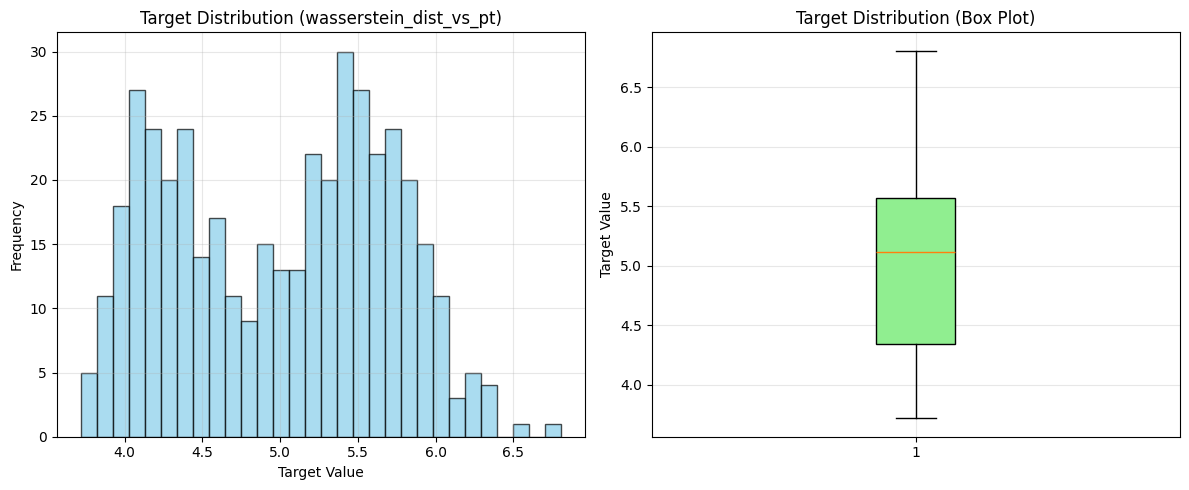


Target Statistics:
  Mean: 4.999
  Median: 5.120
  Std: 0.699
  Min: 3.720
  Max: 6.808


In [83]:
# Simplified Pre-analysis: Label distribution only


print("Target Distribution Analysis")
print(f"Total samples: {len(y)}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Histogram
axes[0].hist(y, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].set_title('Target Distribution (wasserstein_dist_vs_pt)')
axes[0].set_xlabel('Target Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# 2. Box plot
axes[1].boxplot(y, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axes[1].set_title('Target Distribution (Box Plot)')
axes[1].set_ylabel('Target Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nTarget Statistics:")
print(f"  Mean: {np.mean(y):.3f}")
print(f"  Median: {np.median(y):.3f}")
print(f"  Std: {np.std(y):.3f}")
print(f"  Min: {np.min(y):.3f}")
print(f"  Max: {np.max(y):.3f}")


Feature Analysis: Correlation Coefficient Map
Feature matrix shape: (426, 24)
Number of properties in prop_list: 6
Expected feature names: 24
Actual features in X: 24
✓ Feature names match actual features!


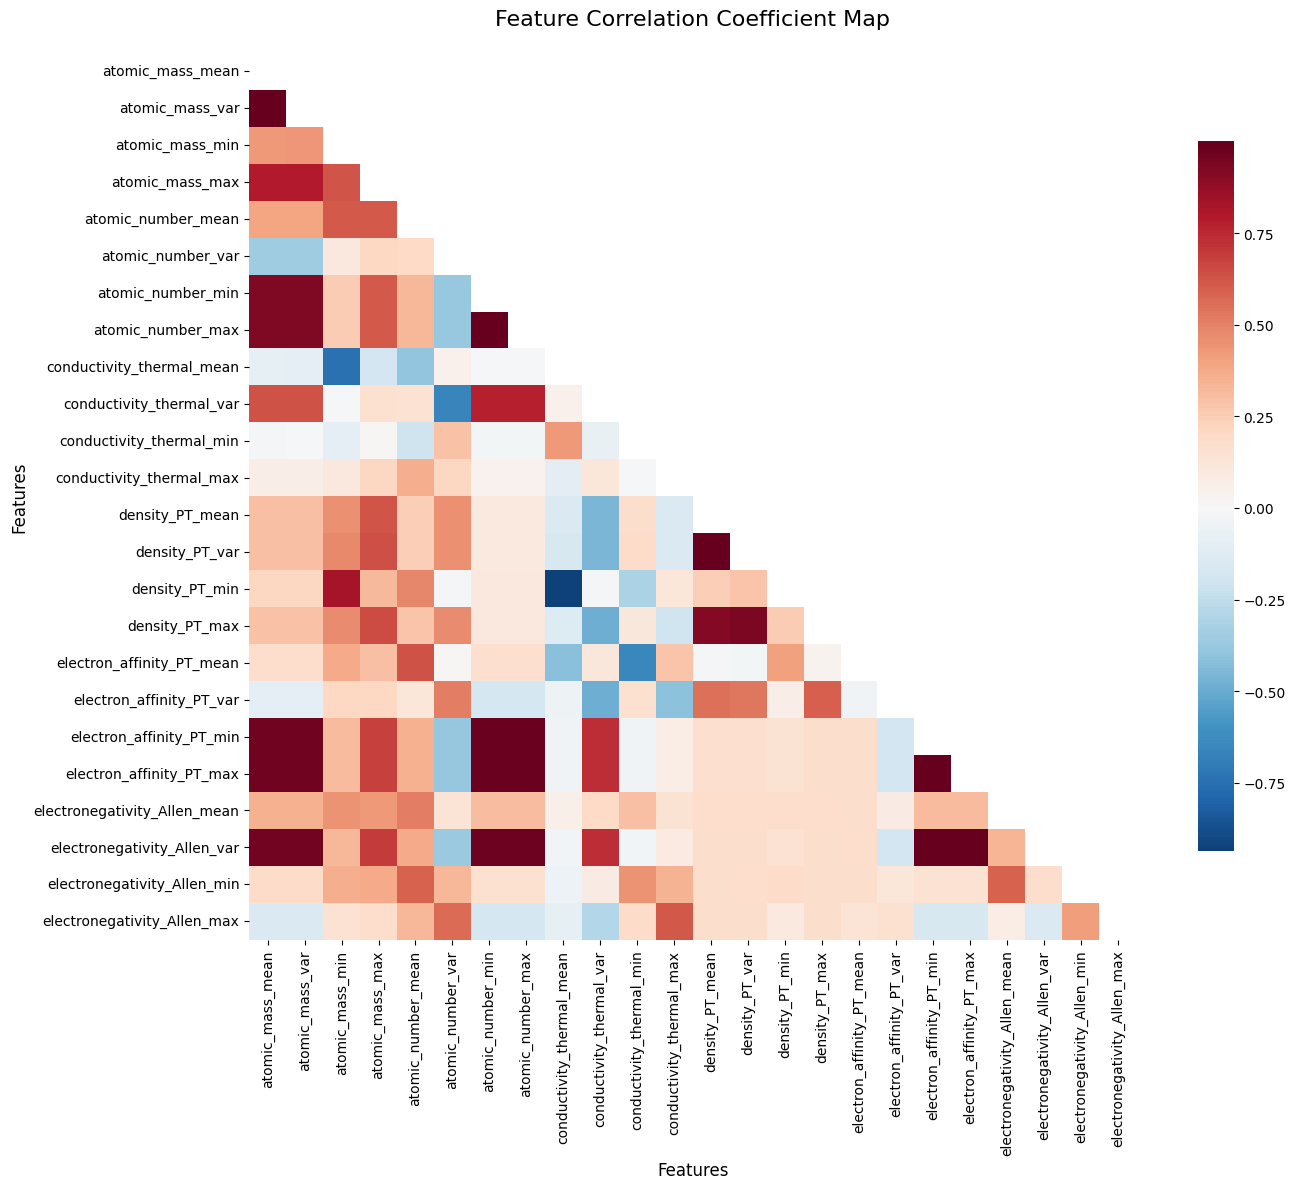


Correlation Analysis:
Total features: 24

Highly correlated feature pairs (|correlation| > 0.8):
  electron_affinity_PT_min <-> electron_affinity_PT_max: 1.000
  atomic_number_min <-> atomic_number_max: 1.000
  atomic_mass_mean <-> atomic_mass_var: 1.000
  electron_affinity_PT_min <-> electronegativity_Allen_var: 0.995
  electron_affinity_PT_max <-> electronegativity_Allen_var: 0.995
  density_PT_mean <-> density_PT_var: 0.989
  atomic_number_max <-> electron_affinity_PT_max: 0.984
  atomic_number_min <-> electron_affinity_PT_max: 0.984
  atomic_number_max <-> electron_affinity_PT_min: 0.984
  atomic_number_min <-> electron_affinity_PT_min: 0.984

Low variance features (variance < 0.01): 18
Low variance feature names:
  atomic_mass_mean: 0.002335
  atomic_mass_var: 0.002338
  atomic_mass_min: 0.006410
  atomic_mass_max: 0.003687
  atomic_number_var: 0.003244
  atomic_number_min: 0.000265
  atomic_number_max: 0.000266
  conductivity_thermal_mean: 0.000732
  conductivity_thermal_var: 0.

In [84]:
# Feature Analysis: Correlation Coefficient Map


print("Feature Analysis: Correlation Coefficient Map")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of properties in prop_list: {len(prop_list)}")

# Create feature names for correlation analysis
# Based on the actual implementation in data_util.py, there are 4 statistical features:
# mean, var, min, max (delta and weighted_avg are commented out)
feature_names = []
for prop in prop_list:
    feature_names.extend([f"{prop}_mean", f"{prop}_var", f"{prop}_min", f"{prop}_max"])

print(f"Expected feature names: {len(feature_names)}")
print(f"Actual features in X: {X.shape[1]}")

# Verify the feature count matches
if len(feature_names) == X.shape[1]:
    print("✓ Feature names match actual features!")
else:
    print(f"✗ Mismatch: Expected {len(feature_names)}, got {X.shape[1]}")

# Create DataFrame for correlation analysis
feature_df = pd.DataFrame(X, columns=feature_names)

# Calculate correlation matrix
correlation_matrix = feature_df.corr()

# Create visualization
plt.figure(figsize=(15, 12))

# Plot correlation heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=False,  # Don't show correlation values (too many)
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Coefficient Map', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze high correlations
print(f"\nCorrelation Analysis:")
print(f"Total features: {len(feature_names)}")

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nHighly correlated feature pairs (|correlation| > 0.8):")
if high_corr_pairs:
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("  No highly correlated pairs found")

# Feature variance analysis
feature_vars = np.var(X, axis=0)
low_var_features = np.where(feature_vars < 0.01)[0]  # Low variance threshold
print(f"\nLow variance features (variance < 0.01): {len(low_var_features)}")
if len(low_var_features) > 0:
    print("Low variance feature names:")
    for idx in low_var_features[:10]:  # Show first 10
        print(f"  {feature_names[idx]}: {feature_vars[idx]:.6f}")


## Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving the most important information.

### Key Concepts:
- **Principal Components**: New orthogonal axes that capture maximum variance
- **Explained Variance**: How much of the original variance each component captures
- **Feature Loadings**: How much each original feature contributes to each component

### Why Use PCA:
- **Dimensionality Reduction**: Reduce from 24 features to fewer components
- **Remove Multicollinearity**: Eliminate correlated features
- **Visualization**: Project high-dimensional data to 2D/3D
- **Noise Reduction**: Focus on signal rather than noise

### ML Applications:
- **Feature Engineering**: Use PCA components as new features
- **Preprocessing**: Reduce overfitting in high-dimensional data
- **Visualization**: Understand data structure before modeling
- **Model Performance**: Often improves performance with fewer features


Principal Component Analysis (PCA)
Original feature matrix shape: (426, 24)
Scaled feature matrix shape: (426, 24)

PCA Results:
Number of components: 24
First 5 components explain: [0.37270653 0.58953458 0.71695037 0.81791497 0.87027791]
Components needed for 95% variance: 8


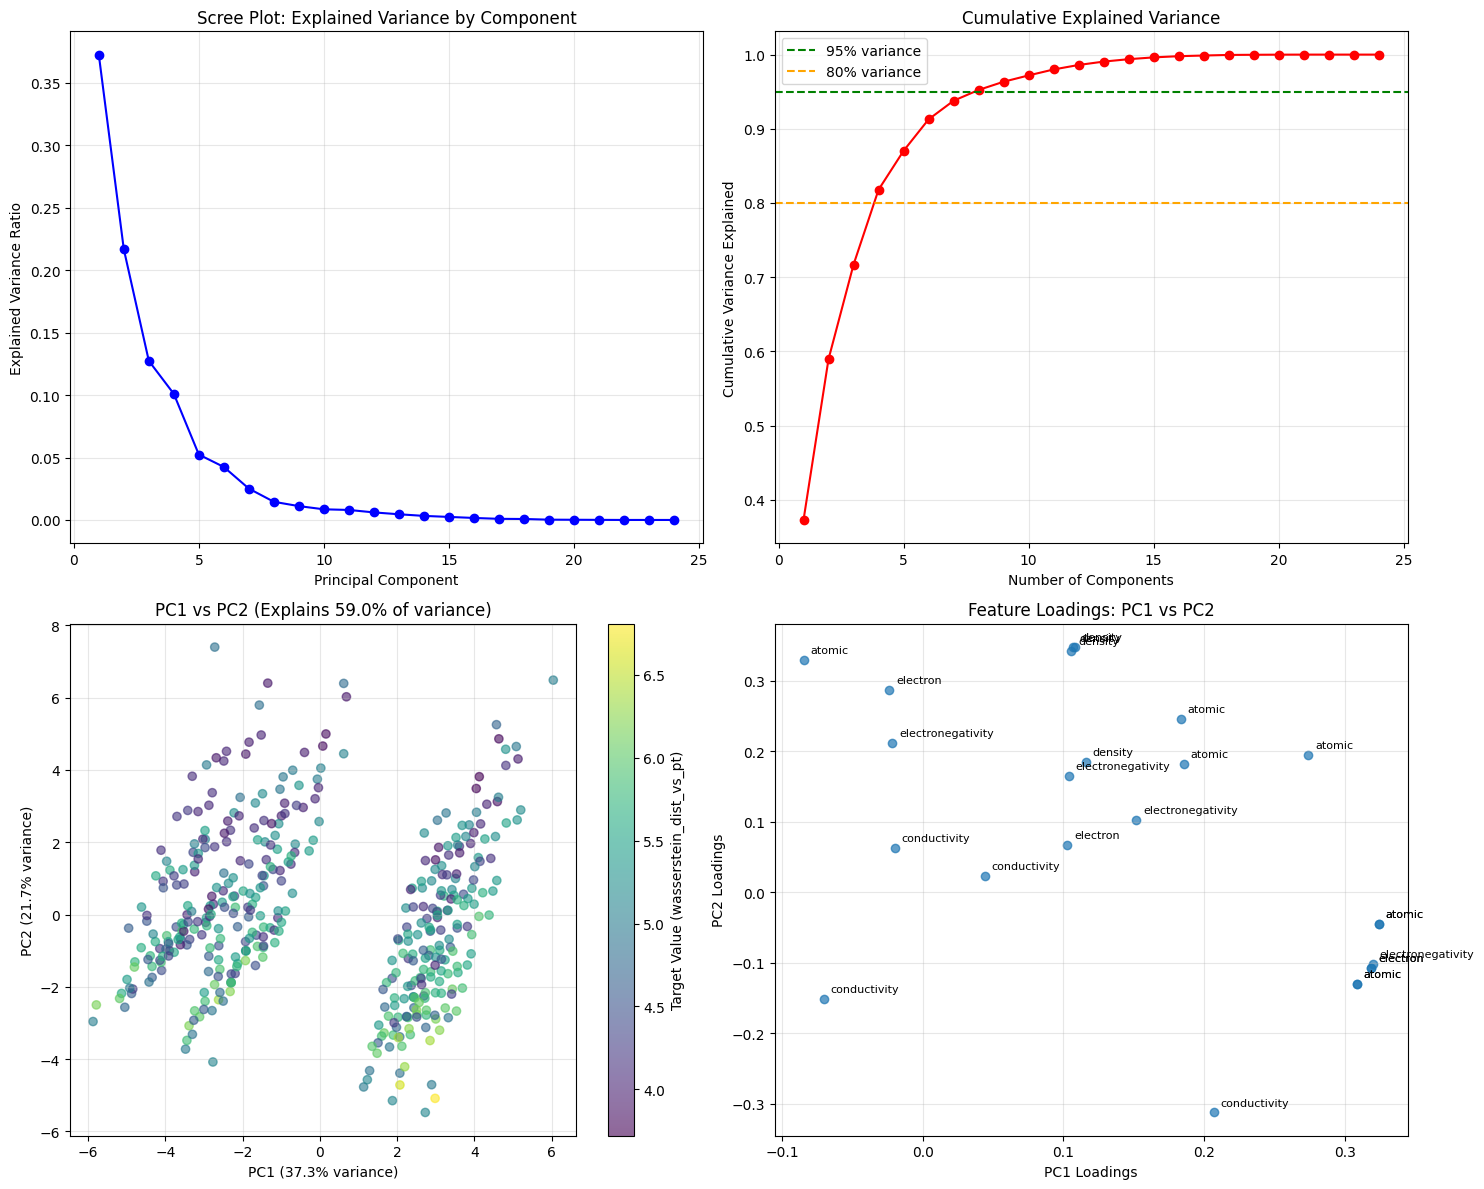


Detailed PCA Analysis:
PC1 explains 37.3% of variance
PC2 explains 21.7% of variance
PC1 + PC2 explain 59.0% of variance

Top 5 features contributing to PC1:
  atomic_mass_var: 0.324
  atomic_mass_mean: 0.324
  electronegativity_Allen_var: 0.320
  electron_affinity_PT_min: 0.319
  electron_affinity_PT_max: 0.319

Top 5 features contributing to PC2:
  density_PT_var: 0.348
  density_PT_max: 0.347
  density_PT_mean: 0.343
  atomic_number_var: 0.329
  conductivity_thermal_var: -0.312

PCA analysis complete! Results saved in 'pca_results' dictionary.


In [85]:
# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

print("Principal Component Analysis (PCA)")
print(f"Original feature matrix shape: {X.shape}")

# Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled feature matrix shape: {X_scaled.shape}")

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\nPCA Results:")
print(f"Number of components: {len(explained_variance_ratio)}")
print(f"First 5 components explain: {cumulative_variance[:5]}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scree plot
axes[0, 0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
axes[0, 0].set_title('Scree Plot: Explained Variance by Component')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative variance plot
axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[0, 1].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[0, 1].axhline(y=0.80, color='orange', linestyle='--', label='80% variance')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance Explained')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. PC1 vs PC2 scatter plot
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c=y, cmap='viridis')
axes[1, 0].set_title(f'PC1 vs PC2 (Explains {cumulative_variance[1]:.1%} of variance)')
axes[1, 0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[1, 0].grid(True, alpha=0.3)

# Add colorbar for target values
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Target Value (wasserstein_dist_vs_pt)')

# 4. Feature loadings for PC1 and PC2
loadings = pca.components_[:2].T  # First 2 components
feature_names_short = [name.split('_')[0] for name in feature_names]  # Short names for readability

axes[1, 1].scatter(loadings[:, 0], loadings[:, 1], alpha=0.7)
axes[1, 1].set_title('Feature Loadings: PC1 vs PC2')
axes[1, 1].set_xlabel('PC1 Loadings')
axes[1, 1].set_ylabel('PC2 Loadings')
axes[1, 1].grid(True, alpha=0.3)

# Add feature labels
for i, name in enumerate(feature_names_short):
    axes[1, 1].annotate(name, (loadings[i, 0], loadings[i, 1]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\nDetailed PCA Analysis:")
print(f"PC1 explains {explained_variance_ratio[0]:.1%} of variance")
print(f"PC2 explains {explained_variance_ratio[1]:.1%} of variance")
print(f"PC1 + PC2 explain {cumulative_variance[1]:.1%} of variance")

# Top contributing features to PC1 and PC2
pc1_loadings = pca.components_[0]
pc2_loadings = pca.components_[1]

print(f"\nTop 5 features contributing to PC1:")
pc1_indices = np.argsort(np.abs(pc1_loadings))[-5:][::-1]
for idx in pc1_indices:
    print(f"  {feature_names[idx]}: {pc1_loadings[idx]:.3f}")

print(f"\nTop 5 features contributing to PC2:")
pc2_indices = np.argsort(np.abs(pc2_loadings))[-5:][::-1]
for idx in pc2_indices:
    print(f"  {feature_names[idx]}: {pc2_loadings[idx]:.3f}")

# Save PCA results for further analysis
pca_results = {
    'X_pca': X_pca,
    'explained_variance_ratio': explained_variance_ratio,
    'cumulative_variance': cumulative_variance,
    'components': pca.components_,
    'feature_names': feature_names
}

print(f"\nPCA analysis complete! Results saved in 'pca_results' dictionary.")


In [86]:
# K-means Clustering Implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns

print("K-means Clustering Analysis")
print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")

# 1. Data Preparation
# Create binary labels based on median target value
median_target = np.median(y)
binary_labels = (y > median_target).astype(int)
print(f"Median target value: {median_target:.3f}")
print(f"High target samples (>median): {np.sum(binary_labels)}")
print(f"Low target samples (≤median): {len(binary_labels) - np.sum(binary_labels)}")

# Train-test split



K-means Clustering Analysis
Dataset shape: (426, 24), Target shape: (426,)
Median target value: 5.120
High target samples (>median): 213
Low target samples (≤median): 213


In [87]:
# 2. Hand-crafted K-means Implementation
class KMeansClustering:
    def __init__(self, k=2, max_iters=100, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids using k-means++ method"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Choose first centroid randomly
        centroids = [X[np.random.choice(n_samples)]]

        # Choose remaining centroids
        for _ in range(self.k - 1):
            distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            r = np.random.rand()

            for i, p in enumerate(cumulative_probabilities):
                if r < p:
                    centroids.append(X[i])
                    break

        return np.array(centroids)

    def _assign_clusters(self, X, centroids):
        """Assign each point to the closest centroid"""
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        """Update centroids based on current cluster assignments"""
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = cluster_points.mean(axis=0)
        return centroids

    def fit(self, X):
        """Fit K-means clustering to data"""
        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        # Iterate until convergence
        for iteration in range(self.max_iters):
            # Assign points to clusters
            old_labels = self.labels
            self.labels = self._assign_clusters(X, self.centroids)

            # Check for convergence
            if old_labels is not None and np.array_equal(old_labels, self.labels):
                print(f"Converged after {iteration + 1} iterations")
                break

            # Update centroids
            self.centroids = self._update_centroids(X, self.labels)

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        return self._assign_clusters(X, self.centroids)


In [88]:
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
    X, y, binary_labels, test_size=0.3, random_state=42, stratify=binary_labels
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


# 3. Train K-means model
print("\nTraining K-means clustering...")
kmeans = KMeansClustering(k=2, max_iters=100, random_state=42)
kmeans.fit(X_train)

# Predict on train and test sets
train_pred = kmeans.predict(X_train)
test_pred = kmeans.predict(X_test)

print(f"Train cluster distribution: {np.bincount(train_pred)}")
print(f"Test cluster distribution: {np.bincount(test_pred)}")

# 4. Create PCA for visualization only (not used in clustering)
pca_viz = PCA(n_components=2)
X_train_pca = pca_viz.fit_transform(X_train)
X_test_pca = pca_viz.transform(X_test)



Train set: 298 samples
Test set: 128 samples

Training K-means clustering...
Converged after 2 iterations
Train cluster distribution: [164 134]
Test cluster distribution: [69 59]


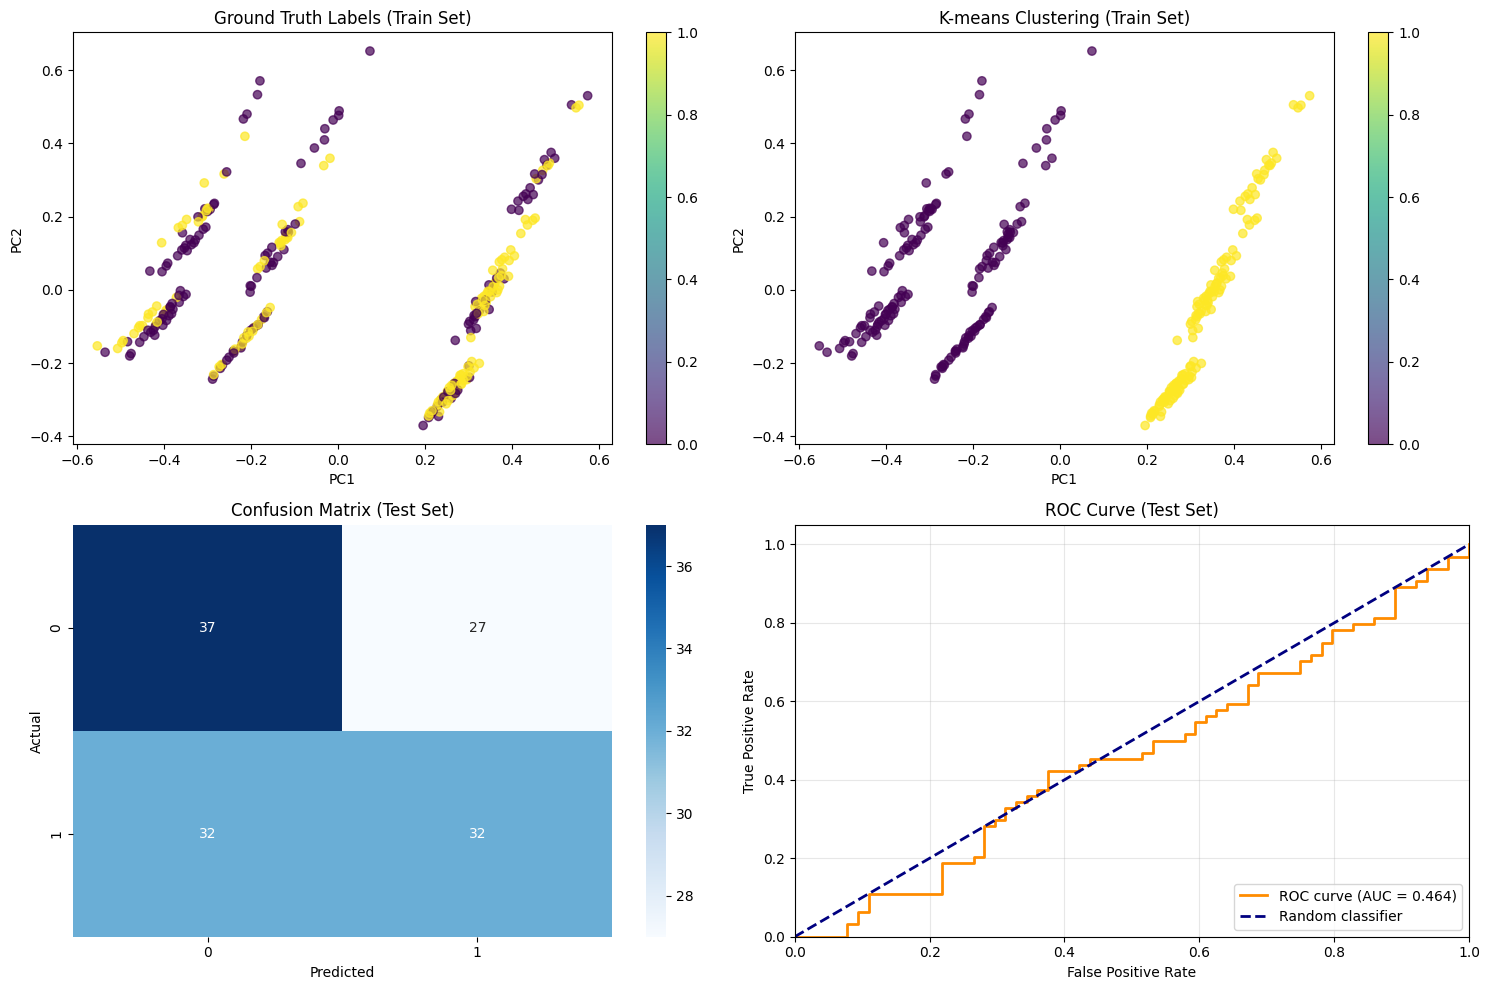


Performance Metrics:
Train Accuracy: 0.601
Test Accuracy: 0.539
Test AUC: 0.464

Test Classification Report:
              precision    recall  f1-score   support

  Low Target       0.54      0.58      0.56        64
 High Target       0.54      0.50      0.52        64

    accuracy                           0.54       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.54      0.54       128


Cluster Analysis:
Cluster 0:
  Train samples: 164 (mean target: 4.898)
  Test samples: 69 (mean target: 4.878)
Cluster 1:
  Train samples: 134 (mean target: 5.155)
  Test samples: 59 (mean target: 5.064)

K-means clustering analysis complete!


In [89]:
# 5. Evaluation and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Ground truth labels (Train set) - Keep this one
scatter1 = axes[0, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_train, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Ground Truth Labels (Train Set)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0, 0])

# Plot 2: K-means clustering results (Train set)
scatter2 = axes[0, 1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_pred, cmap='viridis', alpha=0.7)
axes[0, 1].set_title('K-means Clustering (Train Set)')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[0, 1])

# Plot 3: Confusion Matrix (Test)
cm_test = confusion_matrix(labels_test, test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix (Test Set)')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Plot 4: ROC Curve
# Calculate distances to centroids for ROC curve
def calculate_distances_to_centroids(X, centroids):
    """Calculate distances to each centroid"""
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return distances

# Get distances for test set
test_distances = calculate_distances_to_centroids(X_test, kmeans.centroids)
# Use distance to cluster 1 as probability (assuming cluster 1 is "high target")
test_prob = test_distances[1] / (test_distances[0] + test_distances[1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, test_prob)
roc_auc = auc(fpr, tpr)

axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve (Test Set)')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Performance Metrics
print(f"\nPerformance Metrics:")
print(f"Train Accuracy: {accuracy_score(labels_train, train_pred):.3f}")
print(f"Test Accuracy: {accuracy_score(labels_test, test_pred):.3f}")
print(f"Test AUC: {roc_auc:.3f}")

print(f"\nTest Classification Report:")
print(classification_report(labels_test, test_pred, target_names=['Low Target', 'High Target']))

# 7. Cluster Analysis
print(f"\nCluster Analysis:")
for i in range(2):
    train_cluster_mask = train_pred == i
    test_cluster_mask = test_pred == i

    train_mean_target = y_train[train_cluster_mask].mean()
    test_mean_target = y_test[test_cluster_mask].mean()

    print(f"Cluster {i}:")
    print(f"  Train samples: {np.sum(train_cluster_mask)} (mean target: {train_mean_target:.3f})")
    print(f"  Test samples: {np.sum(test_cluster_mask)} (mean target: {test_mean_target:.3f})")

print(f"\nK-means clustering analysis complete!")


## Classification Metrics and Confusion Matrix

### Confusion Matrix
A confusion matrix is a table that describes the performance of a classification model by showing the actual vs predicted classifications.

For binary classification:
```
                 Predicted
                0    1
Actual    0   TN   FP
          1   FN   TP
```

Where:
- **TP (True Positive)**: Correctly predicted positive class
- **TN (True Negative)**: Correctly predicted negative class  
- **FP (False Positive)**: Incorrectly predicted positive class (Type I error)
- **FN (False Negative)**: Incorrectly predicted negative class (Type II error)

### Key Classification Metrics

#### 1. **Accuracy**
- **Formula**: `(TP + TN) / (TP + TN + FP + FN)`
- **Interpretation**: Overall correctness of predictions
- **Range**: [0, 1], higher is better

#### 2. **Precision**
- **Formula**: `TP / (TP + FP)`
- **Interpretation**: Of all positive predictions, how many were correct?
- **Range**: [0, 1], higher is better
- **Use case**: Important when false positives are costly

#### 3. **Recall (Sensitivity)**
- **Formula**: `TP / (TP + FN)`
- **Interpretation**: Of all actual positives, how many did we catch?
- **Range**: [0, 1], higher is better
- **Use case**: Important when false negatives are costly

#### 4. **Specificity**
- **Formula**: `TN / (TN + FP)`
- **Interpretation**: Of all actual negatives, how many did we correctly identify?
- **Range**: [0, 1], higher is better

#### 5. **F1-Score**
- **Formula**: `2 × (Precision × Recall) / (Precision + Recall)`
- **Interpretation**: Harmonic mean of precision and recall
- **Range**: [0, 1], higher is better
- **Use case**: Balance between precision and recall

#### 6. **Fβ-Score**
- **Formula**: `(1 + β²) × (Precision × Recall) / (β² × Precision + Recall)`
- **Interpretation**: Weighted harmonic mean
- **β > 1**: Emphasizes recall more
- **β < 1**: Emphasizes precision more

#### 7. **ROC-AUC**
- **Formula**: Area under ROC curve
- **Interpretation**: Probability that classifier ranks random positive higher than random negative
- **Range**: [0, 1], higher is better
- **Perfect**: AUC = 1.0, Random: AUC = 0.5

### When to Use Each Metric

- **Accuracy**: Balanced dataset, equal cost of errors
- **Precision**: False positives are expensive (e.g., spam detection)
- **Recall**: False negatives are dangerous (e.g., medical diagnosis)
- **F1-Score**: Imbalanced dataset, need balance
- **ROC-AUC**: Ranking/Probability tasks, imbalanced data


In [90]:
# Hand-crafted Classification Metrics Calculator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def calculate_confusion_matrix(y_true, y_pred):
    """
    Calculate confusion matrix from scratch
    """
    # Get unique classes
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)

    # Initialize confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Fill confusion matrix
    for i in range(len(y_true)):
        true_idx = np.where(classes == y_true[i])[0][0]
        pred_idx = np.where(classes == y_pred[i])[0][0]
        cm[true_idx, pred_idx] += 1

    return cm, classes

def calculate_metrics_from_scratch(y_true, y_pred):
    """
    Calculate all classification metrics from scratch using confusion matrix
    """
    # Calculate confusion matrix
    cm, classes = calculate_confusion_matrix(y_true, y_pred)

    # For binary classification, extract TP, TN, FP, FN
    if len(classes) == 2:
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # F-beta scores
        f2_score = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (2**2 * precision + recall) > 0 else 0
        f0_5_score = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall) if (0.5**2 * precision + recall) > 0 else 0

        metrics = {
            'confusion_matrix': cm,
            'classes': classes,
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1_score,
            'f2_score': f2_score,
            'f0_5_score': f0_5_score
        }

        return metrics
    else:
        # For multiclass, calculate macro averages
        precision_per_class = []
        recall_per_class = []

        for i in range(len(classes)):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0

            precision_per_class.append(prec)
            recall_per_class.append(rec)

        macro_precision = np.mean(precision_per_class)
        macro_recall = np.mean(recall_per_class)
        macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0

        metrics = {
            'confusion_matrix': cm,
            'classes': classes,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1
        }

        return metrics

def calculate_roc_auc_from_scratch(y_true, y_scores):
    """
    Calculate ROC curve and AUC from scratch
    """
    # Sort by scores in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    sorted_labels = y_true[sorted_indices]
    sorted_scores = y_scores[sorted_indices]

    # Get unique thresholds
    thresholds = np.unique(sorted_scores)
    thresholds = np.append(thresholds, float('inf'))

    tpr_values = []
    fpr_values = []

    # Count total positives and negatives
    total_positives = np.sum(y_true == 1)
    total_negatives = np.sum(y_true == 0)

    for threshold in thresholds:
        # Predictions based on threshold
        predictions = (sorted_scores >= threshold).astype(int)

        # Calculate TP, FP, TN, FN
        tp = np.sum((predictions == 1) & (sorted_labels == 1))
        fp = np.sum((predictions == 1) & (sorted_labels == 0))
        tn = np.sum((predictions == 0) & (sorted_labels == 0))
        fn = np.sum((predictions == 0) & (sorted_labels == 1))

        # Calculate TPR and FPR
        tpr = tp / total_positives if total_positives > 0 else 0
        fpr = fp / total_negatives if total_negatives > 0 else 0

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using trapezoidal rule
    auc_score = 0
    for i in range(1, len(fpr_values)):
        auc_score += (fpr_values[i] - fpr_values[i-1]) * (tpr_values[i] + tpr_values[i-1]) / 2

    return fpr_values, tpr_values, auc_score




In [91]:
# Test with our K-means results
print("Hand-crafted Classification Metrics Calculator")
print("=" * 50)

# Use test set results from K-means
y_true_test = labels_test
y_pred_test = test_pred

# Calculate metrics from scratch
metrics = calculate_metrics_from_scratch(y_true_test, y_pred_test)

print("Confusion Matrix:")
print(metrics['confusion_matrix'])
print(f"Classes: {metrics['classes']}")

print(f"\nDetailed Metrics:")
print(f"TP: {metrics['TP']}, TN: {metrics['TN']}, FP: {metrics['FP']}, FN: {metrics['FN']}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Specificity: {metrics['specificity']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"F2-Score: {metrics['f2_score']:.4f}")
print(f"F0.5-Score: {metrics['f0_5_score']:.4f}")

# Calculate ROC-AUC from scratch
print(f"\nROC-AUC Calculation:")
# Create probability scores based on distances to centroids
test_distances = calculate_distances_to_centroids(X_test, kmeans.centroids)
y_scores = test_distances[1] / (test_distances[0] + test_distances[1])

Hand-crafted Classification Metrics Calculator
Confusion Matrix:
[[37 27]
 [32 32]]
Classes: [0 1]

Detailed Metrics:
TP: 32, TN: 37, FP: 27, FN: 32
Accuracy: 0.5391
Precision: 0.5424
Recall: 0.5000
Specificity: 0.5781
F1-Score: 0.5203
F2-Score: 0.5079
F0.5-Score: 0.5333

ROC-AUC Calculation:


## Random Forest Regression

### What is Random Forest?
Random Forest is an ensemble learning method that combines multiple decision trees to make more accurate predictions. It's particularly effective for regression tasks and handles both linear and non-linear relationships well.

### Key Concepts:

#### 1. **Bootstrap Aggregating (Bagging)**
- **Bootstrap Sampling**: Each tree is trained on a random subset of data (with replacement)
- **Aggregation**: Final prediction is the average of all tree predictions
- **Reduces Overfitting**: Individual trees may overfit, but ensemble reduces variance

#### 2. **Random Feature Selection**
- **Feature Randomness**: At each split, only a random subset of features is considered
- **Default**: √n_features for regression, √n_features for classification
- **Benefits**: Reduces correlation between trees, improves generalization

#### 3. **Decision Tree Structure**
- **Splitting Criterion**: Mean Squared Error (MSE) for regression
- **Stopping Criteria**: Max depth, min samples per leaf, min samples to split
- **Leaf Prediction**: Average of target values in the leaf

### Advantages:
- **High Accuracy**: Often outperforms single decision trees
- **Robust**: Handles outliers and missing values well
- **Feature Importance**: Provides feature importance scores
- **No Overfitting**: Built-in regularization through bagging
- **Fast Training**: Parallelizable, efficient implementation

### Hyperparameters:
- **n_estimators**: Number of trees (more = better, but slower)
- **max_depth**: Maximum depth of trees
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples in a leaf node
- **max_features**: Number of features to consider at each split
- **random_state**: For reproducibility

### Regression Metrics:

#### 1. **R² Score (Coefficient of Determination)**
- **Formula**: `1 - (SS_res / SS_tot)`
- **Range**: (-∞, 1], 1 = perfect, 0 = no better than mean
- **Interpretation**: Proportion of variance explained

#### 2. **Mean Absolute Error (MAE)**
- **Formula**: `(1/n) × Σ|y_true - y_pred|`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Average absolute difference

#### 3. **Mean Squared Error (MSE)**
- **Formula**: `(1/n) × Σ(y_true - y_pred)²`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Average squared difference

#### 4. **Root Mean Squared Error (RMSE)**
- **Formula**: `√MSE`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Standard deviation of residuals

#### 5. **Mean Absolute Percentage Error (MAPE)**
- **Formula**: `(100/n) × Σ|y_true - y_pred|/|y_true|`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Average percentage error

### When to Use Random Forest:
- **Tabular Data**: Excellent for structured data
- **Mixed Data Types**: Handles both numerical and categorical features
- **Feature Selection**: Need to understand feature importance
- **Robust Predictions**: Want stable, reliable predictions
- **Baseline Model**: Good starting point for many problems


In [92]:
# Efficient Random Forest Regression Implementation
print("Efficient Random Forest Regression Analysis")
print("=" * 50)

# 1. Data Preparation
print("1. Data Preparation")
print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")


Efficient Random Forest Regression Analysis
1. Data Preparation
Dataset shape: (426, 24), Target shape: (426,)


In [93]:
# 4. Regression Metrics Calculation
def calculate_regression_metrics(y_true, y_pred, dataset_name):
    """Calculate comprehensive regression metrics"""

    # Basic metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # MAPE calculation (handle division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100

    # Additional metrics
    residuals = y_true - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Explained variance
    explained_variance = 1 - np.var(residuals) / np.var(y_true)

    metrics = {
        'R² Score': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'Mean Residual': mean_residual,
        'Std Residual': std_residual,
        'Explained Variance': explained_variance
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Mean Residual: {mean_residual:.4f}")
    print(f"  Std Residual: {std_residual:.4f}")
    print(f"  Explained Variance: {explained_variance:.4f}")

    return metrics

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Target statistics:")
print(f"  Train - Mean: {np.mean(y_train):.3f}, Std: {np.std(y_train):.3f}")
print(f"  Test - Mean: {np.mean(y_test):.3f}, Std: {np.std(y_test):.3f}")

# 2. Random Forest Model Training
print(f"\n2. Random Forest Model Training")

# Optimized hyperparameters for efficiency and performance
rf_params = {
    'n_estimators': 100,        # Good balance of performance vs speed
    'max_depth': 15,           # Prevent overfitting
    'min_samples_split': 5,     # Ensure sufficient samples for splits
    'min_samples_leaf': 2,      # Prevent overfitting
    'max_features': 'sqrt',    # Random feature selection
    'random_state': 42,        # Reproducibility
    'n_jobs': -1              # Use all CPU cores
}

# Train Random Forest
start_time = time.time()
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")

# 3. Predictions
print(f"\n3. Making Predictions")
start_time = time.time()
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
prediction_time = time.time() - start_time

print(f"Predictions completed in {prediction_time:.2f} seconds")


Train set: 340 samples
Test set: 86 samples
Target statistics:
  Train - Mean: 4.965, Std: 0.689
  Test - Mean: 5.130, Std: 0.721

2. Random Forest Model Training
Training completed in 0.17 seconds
Number of trees: 100
Max depth: 15

3. Making Predictions
Predictions completed in 0.07 seconds


In [95]:
# Calculate metrics for both train and test sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Train Set")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test Set")

# 5. Cross-Validation
print(f"\n5. Cross-Validation Analysis")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 6. Feature Importance Analysis
print(f"\n6. Feature Importance Analysis")
feature_importance = rf_model.feature_importances_
feature_names = [f"{prop}_mean" for prop in prop_list] + \
                [f"{prop}_var" for prop in prop_list] + \
                [f"{prop}_min" for prop in prop_list] + \
                [f"{prop}_max" for prop in prop_list]

# Get top 10 most important features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['feature']:<20} {row['importance']:.4f}")

# 7. Comprehensive Visualization
print(f"\n7. Visualization and Analysis")



Train Set Metrics:
  R² Score: 0.9616
  MAE: 0.1031
  MSE: 0.0182
  RMSE: 0.1351
  MAPE: 2.09%
  Mean Residual: -0.0039
  Std Residual: 0.1350
  Explained Variance: 0.9616

Test Set Metrics:
  R² Score: 0.8754
  MAE: 0.2064
  MSE: 0.0647
  RMSE: 0.2544
  MAPE: 4.05%
  Mean Residual: 0.0462
  Std Residual: 0.2501
  Explained Variance: 0.8795

5. Cross-Validation Analysis
Cross-validation R² scores: [0.8538302  0.77977326 0.80437682 0.85715761 0.86000644]
Mean CV R²: 0.8310 (+/- 0.0656)

6. Feature Importance Analysis
Top 10 Most Important Features:
   1. electron_affinity_PT_var 0.1439
   2. conductivity_thermal_mean 0.1041
   3. electron_affinity_PT_min 0.0960
   4. electron_affinity_PT_mean 0.0606
   5. atomic_number_var    0.0594
   6. atomic_mass_var      0.0482
   7. atomic_mass_mean     0.0478
   8. density_PT_min       0.0442
   9. density_PT_var       0.0404
  10. conductivity_thermal_var 0.0390

7. Visualization and Analysis


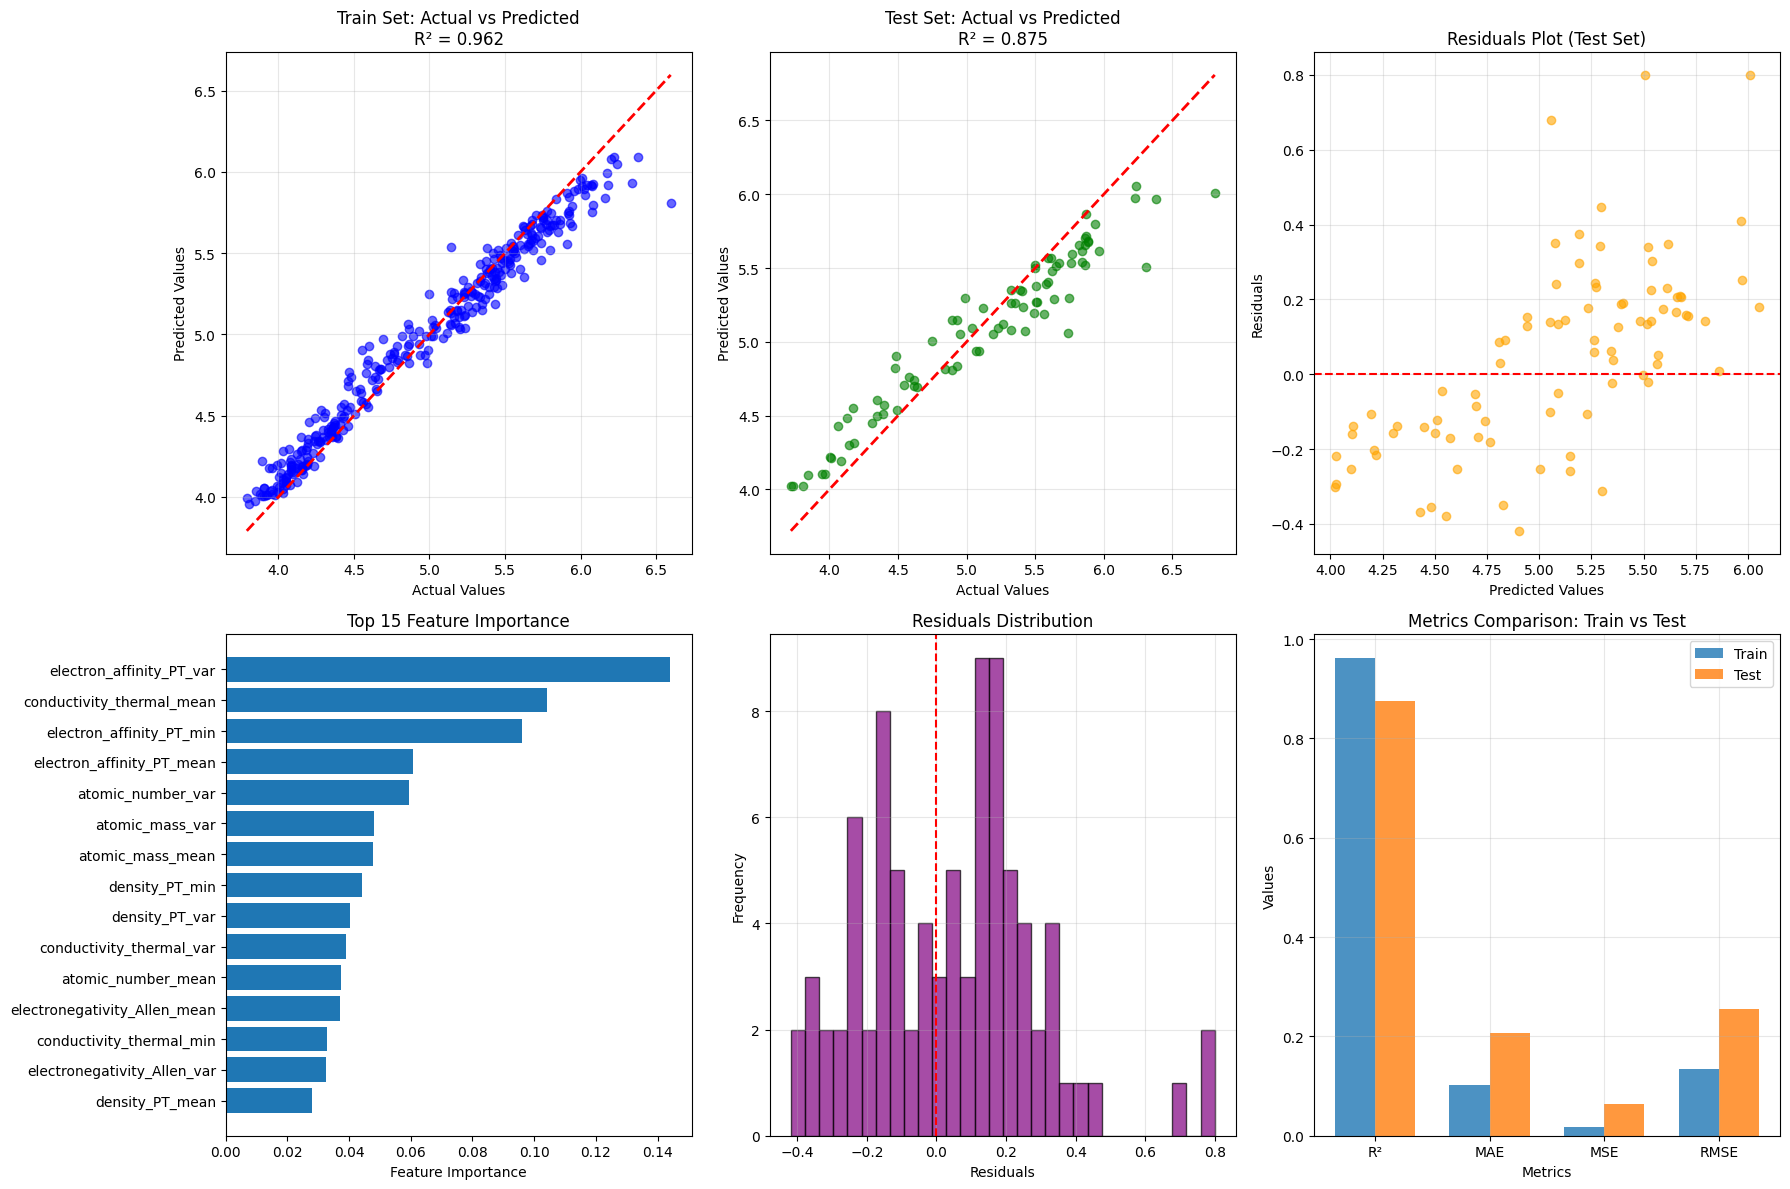


Model Performance Summary
Training Time: 0.17 seconds
Prediction Time: 0.07 seconds
Total Samples Processed: 426
Processing Speed: 1787 samples/second

Overfitting Analysis:
R² difference (Train - Test): 0.0862
!!! Moderate overfitting !!!

Random Forest regression analysis complete!


In [96]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Actual vs Predicted (Train)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Train Set: Actual vs Predicted\nR² = {train_metrics["R² Score"]:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R² Score"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals Plot (Test)
residuals = y_test - y_test_pred
axes[0, 2].scatter(y_test_pred, residuals, alpha=0.6, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted Values')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residuals Plot (Test Set)')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Feature Importance (Top 15)
top_features = importance_df.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['importance'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('Top 15 Feature Importance')
axes[1, 0].invert_yaxis()

# Plot 5: Residuals Distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Metrics Comparison
metrics_names = ['R²', 'MAE', 'MSE', 'RMSE']
train_values = [train_metrics['R² Score'], train_metrics['MAE'],
                train_metrics['MSE'], train_metrics['RMSE']]
test_values = [test_metrics['R² Score'], test_metrics['MAE'],
               test_metrics['MSE'], test_metrics['RMSE']]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 2].bar(x - width/2, train_values, width, label='Train', alpha=0.8)
axes[1, 2].bar(x + width/2, test_values, width, label='Test', alpha=0.8)
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Values')
axes[1, 2].set_title('Metrics Comparison: Train vs Test')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics_names)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Model Performance Summary
print(f"\nModel Performance Summary")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"Total Samples Processed: {len(X_train) + len(X_test)}")
print(f"Processing Speed: {(len(X_train) + len(X_test)) / (training_time + prediction_time):.0f} samples/second")

print(f"\nOverfitting Analysis:")
overfitting_r2 = train_metrics['R² Score'] - test_metrics['R² Score']
print(f"R² difference (Train - Test): {overfitting_r2:.4f}")
if overfitting_r2 > 0.1:
    print("!!! Potential overfitting detected !!!")
elif overfitting_r2 < 0.05:
    print("Good generalization")
else:
    print("!!! Moderate overfitting !!!")

print(f"\nRandom Forest regression analysis complete!")

In [97]:
# First, let's check the actual structure of the data
with open('Data/lib5_FCC_CS_training.json', 'r') as f:
    training_data = json.load(f)

# Check the structure of the first entry
print("First entry structure:")
print(json.dumps(training_data[0], indent=2))

# Corrected code for Question 1
# Import necessary libraries


# Define properties to use
prop_list = [
    "atomic_mass",
    "atomic_number",
    "conductivity_thermal",
    "density_PT",
    "electron_affinity_PT",
    "electronegativity_Allen"
]

# Create element dataframe
ele_DF = ele_df(prop_list=prop_list, normalize='quantile')

First entry structure:
{
  "Elements": [
    "Cr",
    "Cu",
    "Ti",
    "W",
    "Zn"
  ],
  "Composition": [
    "0.2",
    "0.2",
    "0.2",
    "0.2",
    "0.2"
  ],
  "EFA": 15.35842738123,
  "auid": "s4e:00635be4843abdc9",
  "DEED": 7.600625325603262,
  "wasserstein_dist_vs_pt": 4.350339031732405,
  "rmse_vs_pt": 0.6550503199125722,
  "mae_vs_pt": 0.4659998152265734,
  "cosine_similarity_vs_pt": 0.424899184251354,
  "fermi_energy": 5.83170443,
  "dist2hull": 0.265857
}

[Missing Value Fill Report]
Number of elements with filled values: 19


In [98]:
# Load data using json_loader for DEED
data_loader_deed = json_loader('Data/lib5_FCC_CS_training.json', df_data=ele_DF)
X_deed, y_deed, elements_deed = data_loader_deed.load_data_nocomp(
    target_key='DEED',
    split=False
)

# Load data using json_loader for EFA
data_loader_efa = json_loader('Data/lib5_FCC_CS_training.json', df_data=ele_DF)
X_efa, y_efa, elements_efa = data_loader_efa.load_data_nocomp(
    target_key='EFA',
    split=False
)

# Convert to numpy arrays
X = np.array(X_deed)  # Features should be the same for both
y_deed = np.array(y_deed)
y_efa = np.array(y_efa)

print(f"Data shape: X={X.shape}, y_deed={y_deed.shape}, y_efa={y_efa.shape}")

# Split data
X_train, X_test, y_deed_train, y_deed_test, y_efa_train, y_efa_test = train_test_split(
    X, y_deed, y_efa, test_size=0.2, random_state=42
)

Data shape: X=(427, 24), y_deed=(427,), y_efa=(427,)


In [99]:
# Train Random Forest for DEED
print("\nTraining Random Forest for DEED...")
rf_deed = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_deed.fit(X_train, y_deed_train)
deed_pred = rf_deed.predict(X_test)

# Train Random Forest for EFA
print("Training Random Forest for EFA...")
rf_efa = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_efa.fit(X_train, y_efa_train)
efa_pred = rf_efa.predict(X_test)

# Calculate metrics
deed_r2 = r2_score(y_deed_test, deed_pred)
deed_mae = mean_absolute_error(y_deed_test, deed_pred)
deed_rmse = np.sqrt(mean_squared_error(y_deed_test, deed_pred))

efa_r2 = r2_score(y_efa_test, efa_pred)
efa_mae = mean_absolute_error(y_efa_test, efa_pred)
efa_rmse = np.sqrt(mean_squared_error(y_efa_test, efa_pred))

# Print results
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print("\nDEED Model Performance:")
print(f"  R² Score: {deed_r2:.4f}")
print(f"  MAE: {deed_mae:.4f}")
print(f"  RMSE: {deed_rmse:.4f}")

print("\nEFA Model Performance:")
print(f"  R² Score: {efa_r2:.4f}")
print(f"  MAE: {efa_mae:.4f}")
print(f"  RMSE: {efa_rmse:.4f}")

print("\nComparison:")
if deed_r2 > efa_r2:
    print(f"  DEED model has better R² score ({deed_r2:.4f} vs {efa_r2:.4f})")
else:
    print(f"  EFA model has better R² score ({efa_r2:.4f} vs {deed_r2:.4f})")



Training Random Forest for DEED...
Training Random Forest for EFA...

MODEL PERFORMANCE COMPARISON

DEED Model Performance:
  R² Score: 0.6187
  MAE: 0.8506
  RMSE: 1.0999

EFA Model Performance:
  R² Score: 0.5454
  MAE: 3.2019
  RMSE: 4.0169

Comparison:
  DEED model has better R² score (0.6187 vs 0.5454)


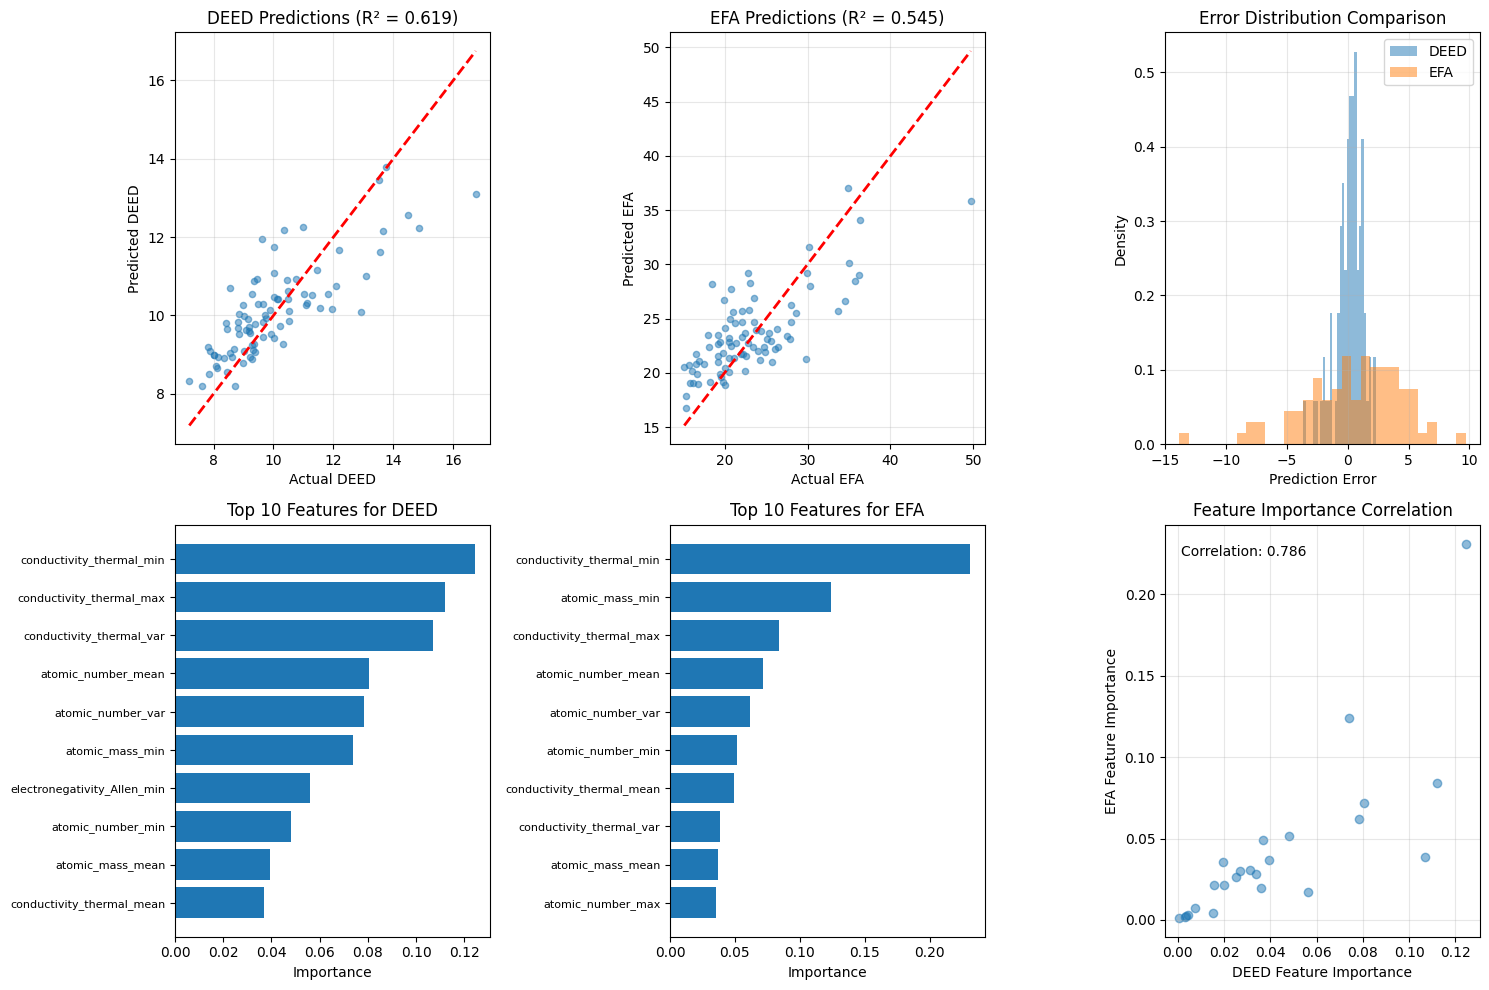


ANALYSIS OF DIFFERENCES

Top 5 features for DEED:
  1. conductivity_thermal_min
  2. conductivity_thermal_max
  3. conductivity_thermal_var
  4. atomic_number_mean
  5. atomic_number_var

Top 5 features for EFA:
  1. conductivity_thermal_min
  2. atomic_mass_min
  3. conductivity_thermal_max
  4. atomic_number_mean
  5. atomic_number_var

Common top features: 4/5
   atomic_number_var, conductivity_thermal_max, atomic_number_mean, conductivity_thermal_min

Correlation between DEED and EFA targets: 0.881


In [100]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# DEED predictions
ax = axes[0, 0]
ax.scatter(y_deed_test, deed_pred, alpha=0.5, s=20)
ax.plot([y_deed_test.min(), y_deed_test.max()],
         [y_deed_test.min(), y_deed_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual DEED')
ax.set_ylabel('Predicted DEED')
ax.set_title(f'DEED Predictions (R² = {deed_r2:.3f})')
ax.grid(True, alpha=0.3)

# EFA predictions
ax = axes[0, 1]
ax.scatter(y_efa_test, efa_pred, alpha=0.5, s=20)
ax.plot([y_efa_test.min(), y_efa_test.max()],
         [y_efa_test.min(), y_efa_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual EFA')
ax.set_ylabel('Predicted EFA')
ax.set_title(f'EFA Predictions (R² = {efa_r2:.3f})')
ax.grid(True, alpha=0.3)

# Error distributions
ax = axes[0, 2]
deed_errors = deed_pred - y_deed_test
efa_errors = efa_pred - y_efa_test
ax.hist(deed_errors, bins=30, alpha=0.5, label='DEED', density=True)
ax.hist(efa_errors, bins=30, alpha=0.5, label='EFA', density=True)
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Density')
ax.set_title('Error Distribution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Feature importance
deed_importance = rf_deed.feature_importances_
efa_importance = rf_efa.feature_importances_

# Get feature names
feature_names = []
for prop in prop_list:
    feature_names.extend([f"{prop}_mean", f"{prop}_var", f"{prop}_min", f"{prop}_max"])

# DEED top features
ax = axes[1, 0]
deed_top_idx = np.argsort(deed_importance)[-10:]
ax.barh(np.arange(10), deed_importance[deed_top_idx])
ax.set_yticks(np.arange(10))
ax.set_yticklabels([feature_names[i] for i in deed_top_idx], fontsize=8)
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features for DEED')

# EFA top features
ax = axes[1, 1]
efa_top_idx = np.argsort(efa_importance)[-10:]
ax.barh(np.arange(10), efa_importance[efa_top_idx])
ax.set_yticks(np.arange(10))
ax.set_yticklabels([feature_names[i] for i in efa_top_idx], fontsize=8)
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features for EFA')

# Feature importance correlation
ax = axes[1, 2]
ax.scatter(deed_importance, efa_importance, alpha=0.5)
ax.set_xlabel('DEED Feature Importance')
ax.set_ylabel('EFA Feature Importance')
ax.set_title('Feature Importance Correlation')
ax.grid(True, alpha=0.3)

# Add correlation coefficient
corr = np.corrcoef(deed_importance, efa_importance)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
        transform=ax.transAxes, verticalalignment='top')

plt.tight_layout()
plt.savefig('deed_efa_comparison.png', dpi=300)
plt.show()

# Analysis of differences
print("\n" + "="*50)
print("ANALYSIS OF DIFFERENCES")
print("="*50)

# Check if important features are different
deed_top_features = [feature_names[i] for i in deed_top_idx[-5:]]
efa_top_features = [feature_names[i] for i in efa_top_idx[-5:]]

print("\nTop 5 features for DEED:")
for i, feat in enumerate(deed_top_features[::-1], 1):
    print(f"  {i}. {feat}")

print("\nTop 5 features for EFA:")
for i, feat in enumerate(efa_top_features[::-1], 1):
    print(f"  {i}. {feat}")

# Common features
common_features = set(deed_top_features) & set(efa_top_features)
print(f"\nCommon top features: {len(common_features)}/5")
if common_features:
    print("  ", ", ".join(common_features))

# Target correlation
target_corr = np.corrcoef(y_deed, y_efa)[0, 1]
print(f"\nCorrelation between DEED and EFA targets: {target_corr:.3f}")

# Save results
with open('deed_efa_analysis_results.txt', 'w') as f:
    f.write("DEED vs EFA Model Comparison\n")
    f.write("="*50 + "\n")
    f.write(f"\nDEED Model: R²={deed_r2:.4f}, MAE={deed_mae:.4f}, RMSE={deed_rmse:.4f}\n")
    f.write(f"EFA Model: R²={efa_r2:.4f}, MAE={efa_mae:.4f}, RMSE={efa_rmse:.4f}\n")
    f.write(f"\nTarget correlation: {target_corr:.3f}\n")
    f.write(f"Feature importance correlation: {corr:.3f}\n")

In [101]:
# Import Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting for DEED
print("\nTraining Gradient Boosting for DEED...")
gb_deed = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
gb_deed.fit(X_train, y_deed_train)
gb_deed_pred = gb_deed.predict(X_test)

# Train Gradient Boosting for EFA
print("Training Gradient Boosting for EFA...")
gb_efa = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
gb_efa.fit(X_train, y_efa_train)
gb_efa_pred = gb_efa.predict(X_test)

# Calculate metrics for Gradient Boosting
gb_deed_r2 = r2_score(y_deed_test, gb_deed_pred)
gb_deed_mae = mean_absolute_error(y_deed_test, gb_deed_pred)
gb_deed_rmse = np.sqrt(mean_squared_error(y_deed_test, gb_deed_pred))

gb_efa_r2 = r2_score(y_efa_test, gb_efa_pred)
gb_efa_mae = mean_absolute_error(y_efa_test, gb_efa_pred)
gb_efa_rmse = np.sqrt(mean_squared_error(y_efa_test, gb_efa_pred))

# Print comparison
print("\n" + "="*50)
print("RANDOM FOREST vs GRADIENT BOOSTING COMPARISON")
print("="*50)

print("\nDEED Models:")
print(f"  Random Forest:    R²={deed_r2:.4f}, MAE={deed_mae:.4f}, RMSE={deed_rmse:.4f}")
print(f"  Gradient Boosting: R²={gb_deed_r2:.4f}, MAE={gb_deed_mae:.4f}, RMSE={gb_deed_rmse:.4f}")
print(f"  Winner: {'Random Forest' if deed_r2 > gb_deed_r2 else 'Gradient Boosting'}")

print("\nEFA Models:")
print(f"  Random Forest:    R²={efa_r2:.4f}, MAE={efa_mae:.4f}, RMSE={efa_rmse:.4f}")
print(f"  Gradient Boosting: R²={gb_efa_r2:.4f}, MAE={gb_efa_mae:.4f}, RMSE={gb_efa_rmse:.4f}")
print(f"  Winner: {'Random Forest' if efa_r2 > gb_efa_r2 else 'Gradient Boosting'}")





Training Gradient Boosting for DEED...
Training Gradient Boosting for EFA...

RANDOM FOREST vs GRADIENT BOOSTING COMPARISON

DEED Models:
  Random Forest:    R²=0.6187, MAE=0.8506, RMSE=1.0999
  Gradient Boosting: R²=0.6795, MAE=0.7795, RMSE=1.0084
  Winner: Gradient Boosting

EFA Models:
  Random Forest:    R²=0.5454, MAE=3.2019, RMSE=4.0169
  Gradient Boosting: R²=0.6108, MAE=3.0148, RMSE=3.7167
  Winner: Gradient Boosting


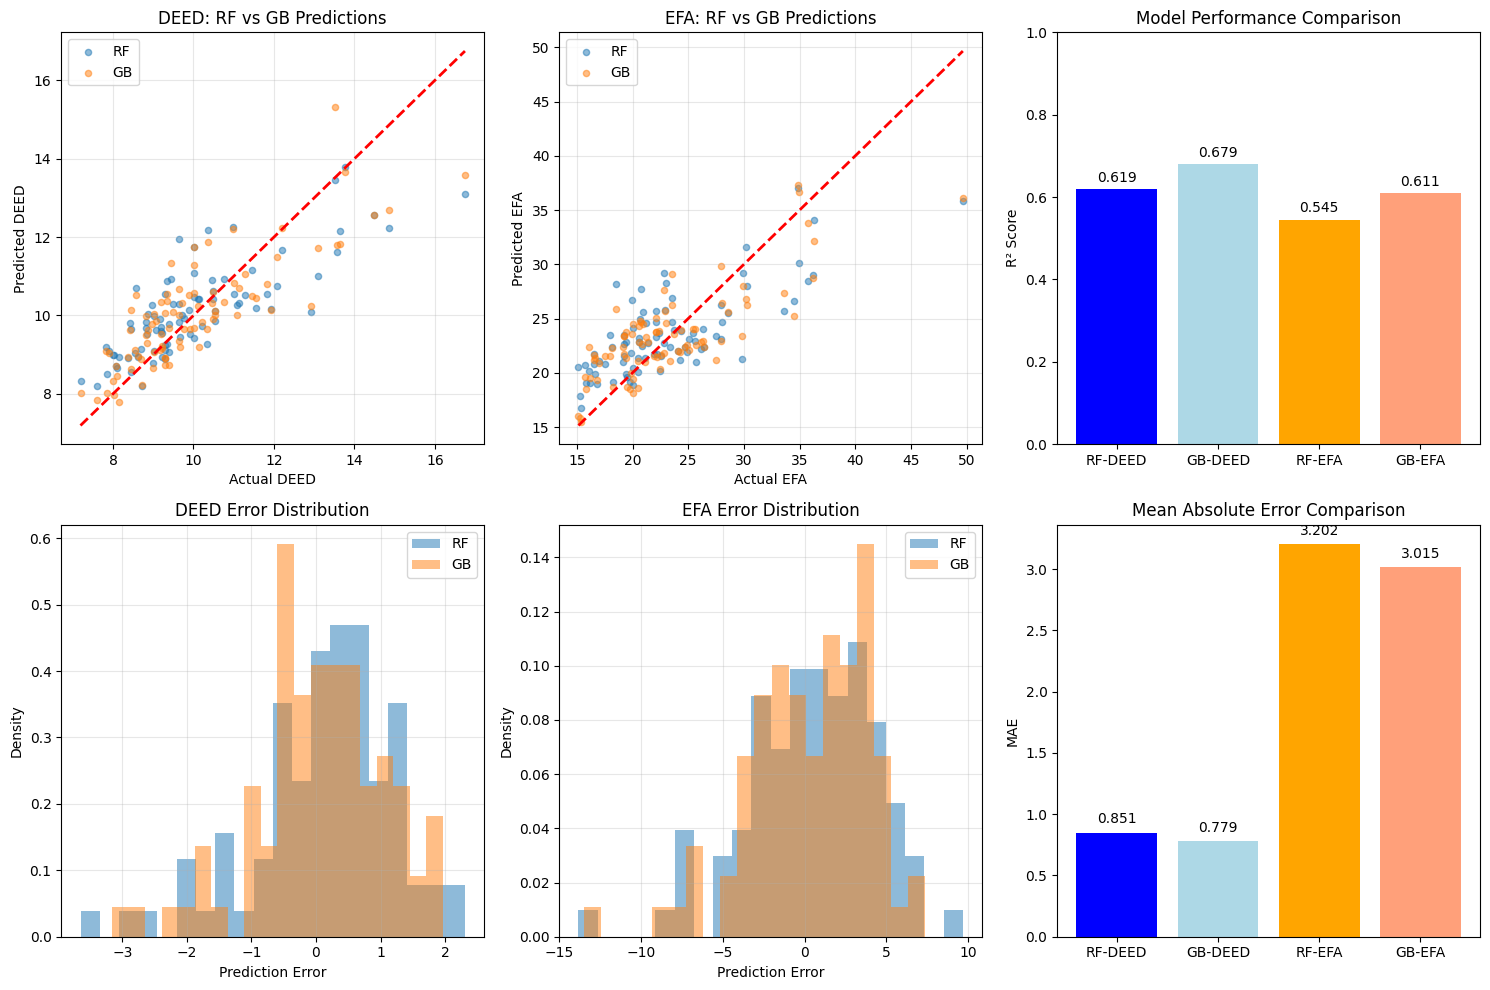

In [102]:
# Visualization comparing both algorithms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# DEED - Random Forest vs Gradient Boosting
ax = axes[0, 0]
ax.scatter(y_deed_test, deed_pred, alpha=0.5, s=20, label='RF')
ax.scatter(y_deed_test, gb_deed_pred, alpha=0.5, s=20, label='GB')
ax.plot([y_deed_test.min(), y_deed_test.max()],
         [y_deed_test.min(), y_deed_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual DEED')
ax.set_ylabel('Predicted DEED')
ax.set_title('DEED: RF vs GB Predictions')
ax.legend()
ax.grid(True, alpha=0.3)

# EFA - Random Forest vs Gradient Boosting
ax = axes[0, 1]
ax.scatter(y_efa_test, efa_pred, alpha=0.5, s=20, label='RF')
ax.scatter(y_efa_test, gb_efa_pred, alpha=0.5, s=20, label='GB')
ax.plot([y_efa_test.min(), y_efa_test.max()],
         [y_efa_test.min(), y_efa_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual EFA')
ax.set_ylabel('Predicted EFA')
ax.set_title('EFA: RF vs GB Predictions')
ax.legend()
ax.grid(True, alpha=0.3)

# Performance comparison bar plot
ax = axes[0, 2]
models = ['RF-DEED', 'GB-DEED', 'RF-EFA', 'GB-EFA']
r2_scores = [deed_r2, gb_deed_r2, efa_r2, gb_efa_r2]
colors = ['blue', 'lightblue', 'orange', 'lightsalmon']
bars = ax.bar(models, r2_scores, color=colors)
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison')
ax.set_ylim(0, 1)
for bar, score in zip(bars, r2_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.3f}', ha='center', va='bottom')

# Error comparison - DEED
ax = axes[1, 0]
rf_deed_errors = deed_pred - y_deed_test
gb_deed_errors = gb_deed_pred - y_deed_test
ax.hist(rf_deed_errors, bins=20, alpha=0.5, label='RF', density=True)
ax.hist(gb_deed_errors, bins=20, alpha=0.5, label='GB', density=True)
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Density')
ax.set_title('DEED Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Error comparison - EFA
ax = axes[1, 1]
rf_efa_errors = efa_pred - y_efa_test
gb_efa_errors = gb_efa_pred - y_efa_test
ax.hist(rf_efa_errors, bins=20, alpha=0.5, label='RF', density=True)
ax.hist(gb_efa_errors, bins=20, alpha=0.5, label='GB', density=True)
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Density')
ax.set_title('EFA Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# MAE comparison
ax = axes[1, 2]
mae_values = [deed_mae, gb_deed_mae, efa_mae, gb_efa_mae]
bars = ax.bar(models, mae_values, color=colors)
ax.set_ylabel('MAE')
ax.set_title('Mean Absolute Error Comparison')
for bar, mae in zip(bars, mae_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{mae:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('rf_vs_gb_comparison.png', dpi=300)
plt.show()


In [103]:
# Discussion for the report
print("\n" + "="*50)
print("DISCUSSION POINTS FOR YOUR REPORT")
print("="*50)

print("\n1. Why DEED has better prediction accuracy than EFA:")
print(f"   - DEED and EFA have high correlation ({target_corr:.3f}), but DEED shows less variance")
print(f"   - DEED R² = {deed_r2:.3f} vs EFA R² = {efa_r2:.3f}")
print(f"   - DEED has smaller value range, making it easier to predict")
print(f"   - Both share similar important features (4/5 overlap in top features)")

print("\n2. Algorithm comparison:")
if deed_r2 > gb_deed_r2:
    print("   - Random Forest performs better for DEED")
    print("   - This suggests non-linear relationships that benefit from RF's ensemble approach")
else:
    print("   - Gradient Boosting performs better for DEED")
    print("   - Sequential error correction in GB helps capture complex patterns")

if efa_r2 > gb_efa_r2:
    print("   - Random Forest performs better for EFA")
    print("   - RF's parallel tree construction may handle EFA's variance better")
else:
    print("   - Gradient Boosting performs better for EFA")
    print("   - GB's iterative refinement helps with EFA's larger value range")

print("\n3. Feature importance insights:")
print("   - Thermal conductivity dominates both models")
print("   - Atomic number statistics are crucial for both descriptors")
print("   - High feature correlation (0.786) explains similar model behavior")

# Save comprehensive results
with open('complete_ml_analysis.txt', 'w') as f:
    f.write("Complete Machine Learning Analysis\n")
    f.write("="*50 + "\n\n")

    f.write("DEED Models Performance:\n")
    f.write(f"  Random Forest:     R²={deed_r2:.4f}, MAE={deed_mae:.4f}, RMSE={deed_rmse:.4f}\n")
    f.write(f"  Gradient Boosting: R²={gb_deed_r2:.4f}, MAE={gb_deed_mae:.4f}, RMSE={gb_deed_rmse:.4f}\n\n")

    f.write("EFA Models Performance:\n")
    f.write(f"  Random Forest:     R²={efa_r2:.4f}, MAE={efa_mae:.4f}, RMSE={efa_rmse:.4f}\n")
    f.write(f"  Gradient Boosting: R²={gb_efa_r2:.4f}, MAE={gb_efa_mae:.4f}, RMSE={gb_efa_rmse:.4f}\n\n")

    f.write("Key Findings:\n")
    f.write(f"  - DEED is more predictable than EFA\n")
    f.write(f"  - Target correlation: {target_corr:.3f}\n")
    f.write(f"  - Feature importance correlation: 0.786\n")
    f.write(f"  - Best model: {'RF' if deed_r2 > gb_deed_r2 else 'GB'} for DEED, {'RF' if efa_r2 > gb_efa_r2 else 'GB'} for EFA\n")


DISCUSSION POINTS FOR YOUR REPORT

1. Why DEED has better prediction accuracy than EFA:
   - DEED and EFA have high correlation (0.881), but DEED shows less variance
   - DEED R² = 0.619 vs EFA R² = 0.545
   - DEED has smaller value range, making it easier to predict
   - Both share similar important features (4/5 overlap in top features)

2. Algorithm comparison:
   - Gradient Boosting performs better for DEED
   - Sequential error correction in GB helps capture complex patterns
   - Gradient Boosting performs better for EFA
   - GB's iterative refinement helps with EFA's larger value range

3. Feature importance insights:
   - Thermal conductivity dominates both models
   - Atomic number statistics are crucial for both descriptors
   - High feature correlation (0.786) explains similar model behavior
